# Sentiment Analysis

Data Mining Techniques, National and Kapodistrian University of Athens 2021-22

A project by:
Giannis Daras (ID: 1115201800040)
and Konstantinos Kitsos (ID: 1115201900082)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import sys

data='../content/drive/MyDrive/eclass_all_with_sentiment_v2.pkl'#edo bale to path pou exeis anabasei esy to diko sou pickle
df_original=pd.read_pickle(data)
df_original.shape


(228207, 17)

**INTRODUCTION - TSV TEXT GENERATION**

In [ ]:
#/content/drive/MyDrive/ΤΕΔΕ1/

# train and test.tsv

#len(df.index) = number of rows
train_len=int(0.8*len(df_original.index)) #this is 80% percent of df length

df_original.iloc[0:train_len,:].to_csv(r'./drive/MyDrive/TEDE1/train.tsv', sep='\t')

df_original.iloc[train_len:,:].to_csv(r'./drive/MyDrive/TEDE1/test.tsv', sep='\t')


**EXERCISE 1 - CLEANUP**

**Handling Nan Values** (it will be proven that they do not exist in the 'text' column)

In [ ]:
df = df_original.copy(deep=True)


print(df.shape)
# Drop rows with empty text field.
df.dropna(subset=['text'], how='all', inplace=True)

df.shape

(228207, 17)


(228207, 17)

The number of lines: remains the same, so each line had non-null text in the 'text' area.



Removing special symbols, links, emojis:

In [ ]:
import nltk
nltk.download('stopwords')

True

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


#df = pd.read_pickle('eclass_all_with_sentiment_v2.pkl')


print('Number of rows and columns:', df.shape)
df1 = df['user_created']
df2 = df['date']


def remove_punctuation(x):
    try:
        x = x.str.replace('[^\w\s]','')
    except:
        pass
    return x


df= df.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True) # links
df["text"]= df["text"].str.replace('[0,1,2,3,4,5,6,7,8,9]', '', case = False)
df = df.apply(remove_punctuation) #remove punctuation
df["text"]=df["text"].str.lower()   # lower case for texts
df["hashtags"]=df["hashtags"].str.lower()   # lower case for hashtags
df['user_created'] = df1
df['date'] = df2

from nltk.corpus import stopwords
stop = stopwords.words('english')

df['text without stopwords'] = df["text"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))

df.head(40)

df.head(40) #quick check


Number of rows and columns: (228207, 17)


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment,text without stopwords
0,1340539111971516416,Rachel Roh,La CrescentaMontrose CA,Aggregator of Asian American news scanning div...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treat a cyt...,pfizerbiontech,Twitter for Android,0,0,False,NEU,folks said daikon paste could treat cytokine s...
1,1338158543359250433,Albert Fong,San Francisco CA,Marketing dude tech geek heavy metal 80s musi...,2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,while the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,NEG,world wrong side history year hopefully bigges...
2,1337858199140118533,eli,Your Bed,heil hydra,2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,coronavirus sputnikv astrazeneca pfizerbiontec...,coronavirus sputnikv astrazeneca pfizerbiontec...,Twitter for Android,0,0,False,NEU,coronavirus sputnikv astrazeneca pfizerbiontec...
3,1337855739918835717,Charles Adler,Vancouver BC Canada,Hosting CharlesAdlerTonight Global News Radio ...,2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,facts are immutable senator even when youre no...,NaN,Twitter Web App,446,2129,False,NEU,facts immutable senator even youre ethically s...
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain to me again why we need a vaccine bori...,whereareallthesickpeople pfizerbiontech,Twitter for iPhone,0,0,False,NEG,explain need vaccine borisjohnson matthancock ...
5,1337852648389832708,Dee,Birmingham England,Gastroenterology trainee Clinical Research Fel...,2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,does anyone have any useful adviceguidance for...,NaN,Twitter for iPhone,0,0,False,NEU,anyone useful adviceguidance whether covid vac...
6,1337851215875608579,Gunther Fehlinger,Austria Ukraine and Kosovo,End North Stream 2 now the pipeline of corrup...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,vaccination,Twitter Web App,0,4,False,NEU,bit sad claim fame success vaccination patriot...
7,1337850832256176136,DrKrutika Kuppalli,NaN,ID Global Health VHF Pandemic Prep Emerging In...,2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,there have not been many bright days in but h...,bidenharris election2020,Twitter for iPhone,2,22,False,POS,many bright days best bidenharris winning elec...
8,1337850023531347969,Erin Despas,NaN,Designingselling on Teespring Like 90s Disney ...,2009-10-30 17:53:54,887,1515,9639,False,2020-12-12 20:01:16,covid vaccine you getting it\n\n covidvaccine ...,covidvaccine covid19 pfizerbiontech moderna,Twitter Web App,2,1,False,NEU,covid vaccine getting covidvaccine covid pfize...
9,1337842295857623042,ChAmjad Ali,Islamabad,ProudPakistani LovePakArmy PMIK insafianspower...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,covidvaccine \n\nstates will start getting cov...,covidvaccine covid19vaccine us pakustv nyc hea...,Twitter Web App,0,0,False,NEU,covidvaccine states start getting covidvaccine...


In [ ]:
df["text"]= df["text"].str.replace('[0,1,2,3,4,5,6,7,8,9,!,~,\',\",@,#,$,%,^,&,*,(,),\-,_,+,=,{,},\[,\],\\,|,;,:,?,/,.,>,<]', '', case = False)
# |-> remove special symbols

def single(tweet):  # remove single letters , single letters don't add substance , only confusion
   new=' '.join( [w for w in tweet.split() if len(w)>1] ) # after the above clean-up for example "didn 't " becomes "didn t", "t" is useless in this case :)
   return new
df["text"]= df["text"].apply(single)

df["text"]= df["text"].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True) # links
df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii')) #emojis
df["text"]=df["text"].str.lower()   # lower case

print(df["text"].tail(20)) #quick check



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


228187    russias sputnikv vaccine has not been authoriz...
228188          apuwall who drtedros we need dates sputnikv
228189    tourists inoculated against covid with the rus...
228190    urban bengaluru covidvaccine availability for ...
228191    bbmp bengaluru covidvaccine availability for a...
228192    urban bengaluru covidvaccine availability for ...
228193    explore your locality like never before with l...
228194    urban bengaluru covidvaccine availability for ...
228195    israel delays entry of tourists vaccinated wit...
228196    antibodies to four covid vaccines differed in ...
228197    bbmp bengaluru covidvaccine availability for a...
228198    urban bengaluru covidvaccine availability for ...
228199    urban bengaluru covidvaccine availability for ...
228200    bbmp bengaluru covidvaccine availability for a...
228201    urban bengaluru covidvaccine availability for ...
228202    urban bengaluru covidvaccine availability for ...
228203    bbmp bengaluru covidvaccine av

Removing stop-words

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop=stopwords.words('english')

other_words=['the','would','could'] #we can add any word that we believe is 'useless' for our data analysis , IDEAS: 'would','could',...
for word in other_words: stop.append(word)

print(stop)

def rem_stop(text,stop):
  tokenized=text.split() # permamently tokenize
  for i in stop:
    if i in tokenized:
       tokenized.remove(i)
  new=' '.join(tokenized) # make it string again
  return new

df['text']=df['text'].apply(lambda x: rem_stop(x,stop))
print(df['text'].tail())#quick check

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**EXERCISE 2**

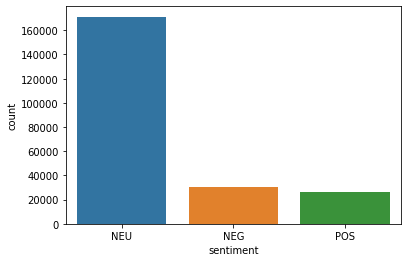

In [ ]:
#import numpy as np

# 2.1

import seaborn as sns

ax = sns.countplot(x="sentiment",data=df)

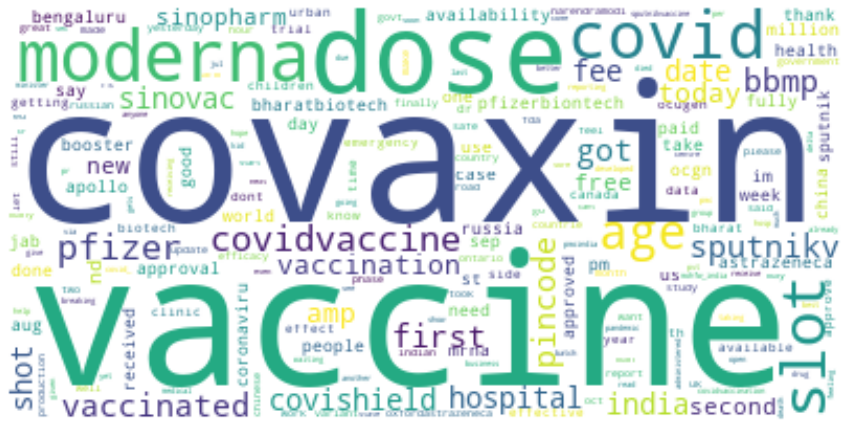

In [ ]:
#  2.2

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt


text = " ".join(i for i in df.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(collocations=False,stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**2.3**

In [ ]:
pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pyfiglet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 865 kB 5.4 MB/s 


           .______     ______        _______.
           |   _  \   /  __  \      /       |
 ______    |  |_)  | |  |  |  |    |   (----`
|______|   |   ___/  |  |  |  |     \   \    
           |  |      |  `--'  | .----)   |   
           | _|       \______/  |_______/    
                                             

           __________________________________
          |__________________________________|






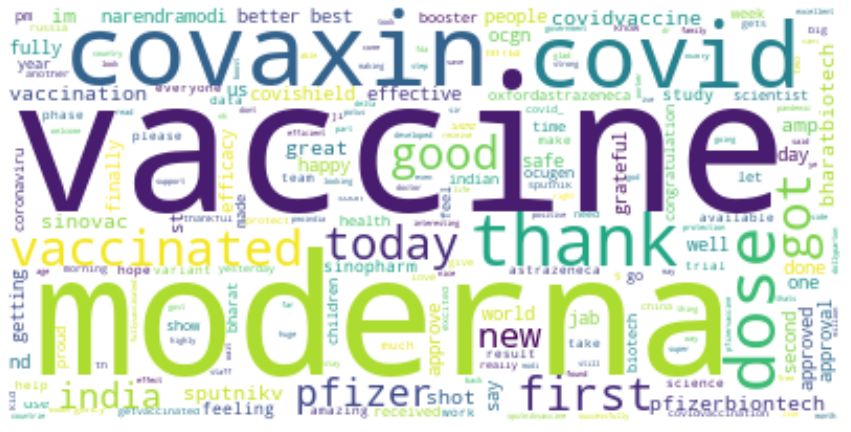











           .__   __.  _______   _______ 
           |  \ |  | |   ____| /  _____|
 ______    |   \|  | |  |__   |  |  __  
|______|   |  . `  | |   __|  |  | |_ | 
           |  |\   | |  |____ |  |__| | 
           |__| \__| |_______| \______| 
                                        

           _______________________________
          |_______________________________|






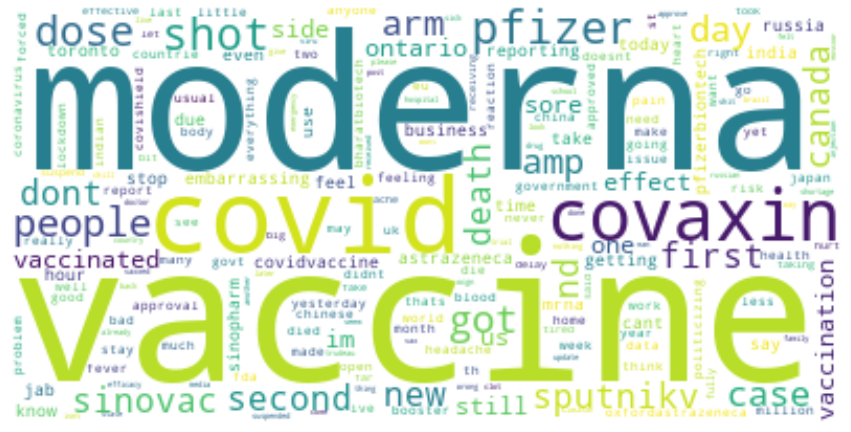











           .__   __.  _______  __    __  
           |  \ |  | |   ____||  |  |  | 
 ______    |   \|  | |  |__   |  |  |  | 
|______|   |  . `  | |   __|  |  |  |  | 
           |  |\   | |  |____ |  `--'  | 
           |__| \__| |_______| \______/  
                                         

           ________________________________
          |________________________________|






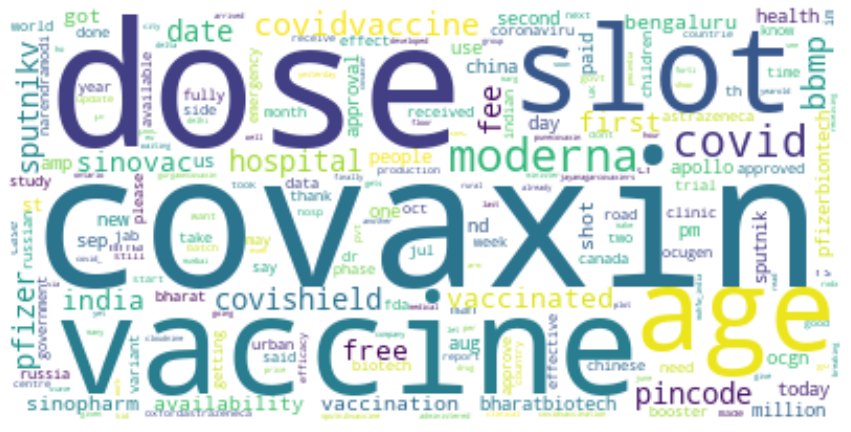

In [ ]:
import sys

from colorama import init
init(strip=not sys.stdout.isatty()) # strip colors if stdout is redirected
from termcolor import cprint
from pyfiglet import figlet_format



df4 = df.loc[df['sentiment'] == 'POS']
df4.head(40)


cprint(figlet_format('- POS', font='starwars'),'yellow', 'on_red', attrs=['bold'])
print("           __________________________________")
print("          |__________________________________|\n\n\n\n")
text = " ".join(i for i in df4.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(collocations=False,stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


print("\n\n\n\n\n\n\n\n\n")
cprint(figlet_format('- NEG', font='starwars'),'yellow', 'on_red', attrs=['bold'])
print("           _______________________________")
print("          |_______________________________|\n\n\n\n")
df5 = df.loc[df['sentiment'] == 'NEG']
df5.head(40)

text = " ".join(i for i in df5.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(collocations=False,stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


print("\n\n\n\n\n\n\n\n\n")
cprint(figlet_format('- NEU', font='starwars'),'yellow', 'on_red', attrs=['bold'])
print("           ________________________________")
print("          |________________________________|\n\n\n\n")
df6 = df.loc[df['sentiment'] == 'NEU']
df6.head(40)

text = " ".join(i for i in df6.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(collocations=False,stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
#2.4

contain_values = df[df['text'].str.contains("astrazeneca") == True]   #choose tweets which contain word astrazeneca and create dataframe "df7"
df7 = pd.DataFrame(contain_values)
df7


contain_values1 = df[df['text'].str.contains("moderna") == True]    #choose tweets which contain word moderna and pfiser or biontech and create dataframe "df9"
df8 = pd.DataFrame(contain_values1)
contain_values1 = df8[df8['text'].str.contains("pfizer","biontech") == True]
df9 = pd.DataFrame(contain_values1)
df9

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment,text without stopwords
2,1337858199140118533,eli,Your Bed,heil hydra,2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,coronavirus sputnikv astrazeneca pfizerbiontec...,coronavirus sputnikv astrazeneca pfizerbiontec...,Twitter for Android,0,0,False,NEU,coronavirus sputnikv astrazeneca pfizerbiontec...
8,1337850023531347969,Erin Despas,NaN,Designingselling on Teespring Like 90s Disney ...,2009-10-30 17:53:54,887,1515,9639,False,2020-12-12 20:01:16,covid vaccine getting covidvaccine covid pfize...,covidvaccine covid19 pfizerbiontech moderna,Twitter Web App,2,1,False,NEU,covid vaccine getting covidvaccine covid pfize...
47,1340129728229871617,Vishwas Gaitonde,NaN,A man of the quill of the pill Of pens syri...,2012-09-30 20:00:54,1162,239,4514,False,2020-12-19 03:00:00,us fda approved two coronavirus vaccines pfize...,fda coronavirus pfizerbiontech moderna vaccines,Twitter Web App,0,0,False,NEU,us fda approved two coronavirus vaccines pfize...
78,1338572995992969217,Toni Kappesz,BERLIN,NaN,2009-06-08 12:38:48,221,483,58673,False,2020-12-14 19:54:06,warpspeed money go covid pioneers pfizerbionte...,warpspeed pfizerbiontech moderna griftertrump,Twitter for iPhone,0,0,False,NEU,warpspeed money go covid pioneers pfizerbionte...
96,1338546341404930050,Human_90,Madchester,Fighting For Freedom \nIm not a Q left or ...,2020-10-07 20:38:10,590,987,7609,False,2020-12-14 18:08:11,pandemic pcrgate condemic billgatesisnotadocto...,pcrgate condemic billgatesisnotadoctor pfizerb...,Twitter Web App,0,2,False,NEG,pandemic pcrgate condemic billgatesisnotadocto...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226951,1461696236160012291,Kamal Vaid,Auf der Schwinge der Walküre,IT and Business Consultant Tweets are personal...,2010-04-24 23:50:38,2340,204,43,False,2021-11-19 14:01:54,us_fda efforts going back two companies pfizer...,pfizer moderna,Twitter Web App,5,44,False,NEU,us_fda efforts going back two companies pfizer...
226957,1461691315037650946,Spectre,NaN,Lover of badass music,2019-08-29 17:38:50,2,44,53,False,2021-11-19 13:42:21,covaxin ocugen amp bharatbiotech needed us can...,covaxin pfizer moderna,Twitter for Android,1,4,False,NEU,covaxin ocugen amp bharatbiotech needed us can...
227160,1461502396568383490,Tomasso,London,Have an amazing day,2021-06-04 21:37:43,20,83,1442,False,2021-11-19 01:11:39,repthomasmassie covaxin vaccin approved fda ye...,NaN,Twitter for Android,1,4,False,NEU,repthomasmassie covaxin vaccin approved fda ye...
227403,1461148676991168512,Neb Sivad,Chicago,NaN,2009-03-05 17:49:14,1,10,81,False,2021-11-18 01:46:06,whitehouse maybe covaxin available know owe so...,covaxin pfizer moderna,Twitter Web App,0,12,False,NEU,whitehouse maybe covaxin available know owe so...


Text(0.5, 1.0, 'astra-zeneka')

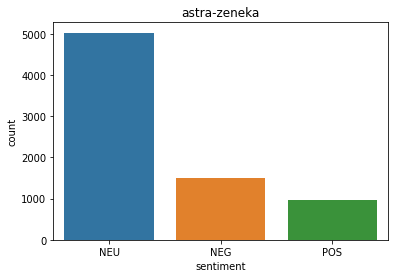

In [ ]:
ax1 = sns.countplot(x="sentiment",data=df7)
ax1.set_title('astra-zeneka')

Text(0.5, 1.0, 'moderna-pfizer')

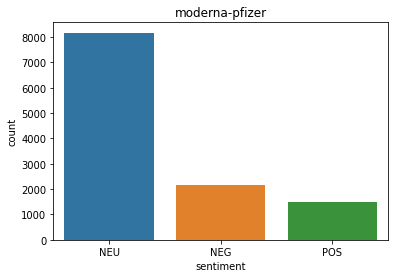

In [ ]:
ax2 = sns.countplot(x="sentiment",data=df9)
ax2.set_title('moderna-pfizer')

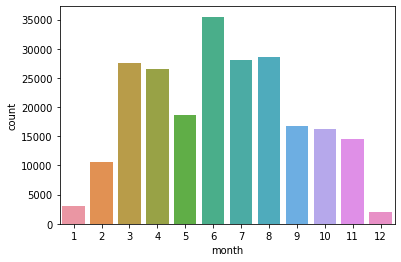

In [ ]:
#2.5

df['month'] = pd.DatetimeIndex(df['date']).month
df.head(50)
ax3 = sns.countplot(x="month",data=df)

**2.5-TOP 5 MONTHS:** Most tweets are in **June** with around 35,500 tweets, followed by **March, April, July, and August** (all with 26,000-29,000 tweets).

**2.5-OBSERVATIONS**

**March 2021:** Approval of Johnson & Johnson
"On February 27, 2021, the Food and Drug Administration issued an Emergency Use Authorization (EUA) for the Janssen COVID-19 vaccine."

**June 2021:** 'Delta' Variant Mutation, additionally: "European Digital Vaccination Certificate in effect."

Other excerpts from news:

"June 1, 2021
The Delta variant, first identified in India in late 2020, becomes the dominant variant in the U.S."

July 30, 2021: "A MMWR notes an increase in breakthrough infections in Barnstable County, Massachusetts in July 2021."

August 30, 2021
ACIP recommends Pfizer-BioNTech’s vaccine for people ages 16 years and older.



**EXERCISE 3**

**BAG OF WORDS**

In [ ]:
dfsub=df.head(10000)

In [ ]:
#BAG OF WORDS
import pickle
import operator
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus.reader.bnc import BNCWordView

vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(dfsub['text'].tolist())
print(vectorizer.get_feature_names())
print(bow.toarray())

#PICKLE-STORING
#open a file, where you ant to store the data
file = open('bow-file', 'wb')

# dump information to that file
pickle.dump(bow, file)

# close the file
file.close()



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['__ice', '_africanunion', '_b_meyer', '_emmalou', '_karlchua', '_loveliberty', '_robbiemoore', '_scgp_', '_snowbunting', '_theenquirer', '_thenmh', '_what', 'a__alimov', 'aacommunities', 'aafp', 'aampa', 'aampe', 'aap', 'aathans', 'aayega', 'aayog', 'ab', 'ab_peds', 'aballinga', 'abbastermezi', 'abbiesbrooks', 'abbvie', 'abc', 'abcnews', 'abcworldnews', 'abdallahdaar', 'abdullah', 'aberfeldy', 'ability', 'abilo', 'abingtonparkmedicalcentre', 'able', 'abline', 'abo', 'aborted', 'abou', 'about', 'abouteua', 'abouthungary', 'abpoli', 'abroad', 'abs', 'abscbnnews', 'absence', 'absolute', 'absolutely', 'abstaining', 'abt', 'abudhabi', 'abudhabilife', 'abundance', 'abus', 'abuse', 'ac', 'academic', 'academics', 'acc', 'accelerating', 'acceleration', 'accept', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessibility', 'accessible', 'accident', 'accidental', 'accidentally', 'accommodating', 'accomplished', 'accomplishment', 'accomplishments', 'accord', 'accordi', 'according'

**TF-IDF:**

Here we print the idf_weights of words in ascending order.

Attention: the tf-idf model we will use in exercise 4 is below.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#import CountVectorizer


#instantiate CountVectorizer()
cv=CountVectorizer()
# this steps generates word counts for the words in your docs
word_count_vector=cv.fit_transform(dfsub['text without stopwords'])

word_count_vector.shape

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
# sort ascending
df_idf.sort_values(by=['idf_weights'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weights
vaccine,1.926946
pfizerbiontech,2.168062
covid,2.321356
moderna,3.063668
first,3.343507
...,...
indiafightscovid,9.517293
indiahottopics,9.517293
indiainpakistan,9.517293
indiana,9.517293


Print the tf-idf value
(the final model is in the next section)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#import CountVectorizer
# this is a very toy example, do not try this at home unless you want to understand the usage differences


# count matrix
count_vector=cv.transform(dfsub['text without stopwords'])
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(count_vector)   # μονο για εκτύπωση αποτε

feature_names = cv.get_feature_names()
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]
#print the scores
dfs = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
dfs.sort_values(by=["tfidf"],ascending=False)

#dfs.head(40)




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
cytokine,0.408029
daikon,0.408029
paste,0.408029
storm,0.390646
treat,0.354320
...,...
fraud,0.000000
fraudnation,0.000000
frauds,0.000000
fraught,0.000000


TF-IDF model we will use in exercise 4

In [ ]:
#TF_IDF
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=1000,
stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(dfsub['text'].tolist())
print( tfidf.shape) #the output is a numpy array of features
print(tfidf.toarray())

#PICKLE-STORE
file = open('tf-file', 'wb')
pickle.dump(tfidf, file)
file.close()

(10000, 1000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**WORD 2 VEC**

In [ ]:
#WORD2VEC

tokenized_tweets = list(dfsub['text'].apply(lambda x: x.split())) # tokenizing
import gensim

model_w2v = gensim.models.Word2Vec(
 tokenized_tweets,
 size=200, # desired no. of features/independent variables
 window=5, # context window size
 min_count=1,
 sg = 1, # 1 for skip-gram model
 hs = 0,
 negative = 10, # for negative sampling
 workers= 2, # no.of cores
 seed = 34)
model_w2v.train(tokenized_tweets, total_examples= len(df1), epochs=20)
print(len(model_w2v.wv.vocab))






15495


In [ ]:
# w2v_for_tweets

averages=[]
for i in range(0,len(tokenized_tweets)): # gia kathe tweet
  sum=[]
  for word in tokenized_tweets[i]:     # gia kathe leksi sto tweet
    if len(sum)==0:    #( sthn arxh kanoyme initialize to sum me to array dianysmaton ths proths leksis   )
      sum= model_w2v.wv[word]
    else:
      sum=np.add(sum,model_w2v.wv[word])  # prosthese ta dianysmata ths lekksis sto sum
    #print(sum)
  averages.append(sum/len(tokenized_tweets[i]))   # bres average ton dianosmaton kanontas average=sum/len(tweet)

print(averages[0]) # this is the array for the first tweet

#PICKLE-STORE
file = open('w2v-file', 'wb')
pickle.dump(averages, file)
file.close()



[ 0.13953196  0.15410738 -0.00736455 -0.04505376  0.05298601  0.10122198
  0.17556301  0.04023663 -0.22334515 -0.14167204 -0.13031182 -0.22659983
  0.12352064  0.05026874  0.02075092  0.19178268  0.09547691  0.10265326
 -0.01927928 -0.03941066  0.05515851 -0.07920571  0.23694634 -0.04269372
 -0.25193745 -0.02091379  0.04538944 -0.24851452  0.29013482 -0.05735802
  0.08697861 -0.00965362 -0.00057387  0.06680527 -0.02638607 -0.06854348
  0.17486861 -0.14347084 -0.16761568  0.18312453 -0.06542881  0.01326342
 -0.14759867 -0.17463598 -0.02240205 -0.17008878  0.15689191 -0.0369671
  0.05642551 -0.00089974 -0.18997265 -0.02500713 -0.09398624  0.17055562
 -0.02130828  0.19006075 -0.02554066 -0.08018336  0.1528397   0.24004772
  0.05676398  0.12447391 -0.20134546  0.09205249  0.228955   -0.02387415
 -0.0394324  -0.06184496  0.04273985  0.04017391 -0.00891718  0.08291456
  0.09463692  0.02056145 -0.17942339  0.06600728  0.14780177  0.08809258
 -0.10158046  0.11692441  0.01310234 -0.00466536  0.

WHEN LOADING THE w2v-file, WE WILL ASSIGN IT THE NAME w2v-data
(IT WILL BE THE AVERAGES-ARRAY (LIST-OF-LISTS) WE CREATED ABOVE)

The w2v-data will be the DATA, and the 'sentiment' column (as in every case) the TARGET


**EXERCISE 4**


In [ ]:
# LOAD BOW , TF-IDF  AND W2V DATA

file = open('bow-file', 'rb')
bow1 = pickle.load(file)
file.close()
bow_data=bow1.toarray()
target=list(dfsub['sentiment'])
print('target')
print(target)

file = open('tf-file', 'rb')
tf = pickle.load(file)
file.close()
tf_data=tf.toarray()
#target=list(df1['sentiment'])  , SAME TARGET


#LOAD-TEST
file = open('w2v-file', 'rb')
w2v_data = pickle.load(file)
#target=list(df1['sentiment'])  , SAME TARGET
file.close()


target
['NEU', 'NEG', 'NEU', 'NEU', 'NEG', 'NEU', 'NEU', 'POS', 'NEU', 'NEU', 'NEG', 'POS', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEG', 'NEU', 'NEU', 'NEU', 'NEU', 'POS', 'NEU', 'NEU', 'NEU', 'POS', 'NEU', 'NEG', 'NEG', 'NEU', 'NEU', 'NEU', 'NEU', 'NEG', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEG', 'NEG', 'NEU', 'NEU', 'NEU', 'NEG', 'POS', 'NEU', 'NEU', 'NEU', 'NEU', 'POS', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEG', 'NEU', 'NEU', 'NEU', 'POS', 'NEG', 'NEU', 'NEG', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'POS', 'NEU', 'NEU', 'NEU', 'NEU', 'NEG', 'NEU', 'POS', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'POS', 'POS', 'NEU', 'POS', 'NEU', 'POS', 'NEG', 'NEG', 'NEU', 'NEU', 'NEU', 'NEU', 'POS', 'POS', 'NEU', 'NEU', 'POS', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEG', 'NEU', 'NEG', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'POS', 'POS', 'NEU', 'NEU', 'POS', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'POS', 'NEU', 'NEU', 'NEU', 'POS', 'NEU', 'NEU'

In [ ]:
#LIBRARIES-SKLEARN
from sklearn import datasets
from sklearn.model_selection import train_test_split


In [ ]:
#DEFINE TEST N TRAIN DATA

x_train_bow,x_test_bow,y_train_bow,y_test_bow=train_test_split(bow_data,target,test_size=0.2,random_state=209)  # bow   ,yes x_train means x_train_bow
####################################
x_train_tf,x_test_tf,y_train_tf,y_test_tf=train_test_split(tf_data,target,test_size=0.2,random_state=209) # tf
x_train_w2v,x_test_w2v,y_train_w2v,y_test_w2v=train_test_split(w2v_data,target,test_size=0.2,random_state=209) #w2v

# remember target=list(df1['sentiment'])


In [ ]:
# 10 cross validation

from sklearn import metrics
from sklearn.model_selection import cross_val_score

def print_metrics(model,data,target): # in place of model we can have SVN/RF/KNN-model
  print('precision ',cross_val_score(model,data,target, cv=10, scoring='precision_weighted'))
  print('recall ', cross_val_score(model,data,target, cv=10, scoring='recall_weighted'))
  print('F1',cross_val_score(model,data,target, cv=10, scoring='f1_weighted'))
  print('ACCURACY',cross_val_score(model,data,target, cv=10, scoring='accuracy') )


**Exercise 4 at this point:** we have defined for bow, tf, and w2v which will be the xtrain, ytrain, xtest, and ytest data. Also, above, we created print_metrics, where we evaluate the classifiers with 10 cross validations.

4-classifiers:

In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# SVM -BOW

#CREATE CLASSIFIER FOR BOW
#Create a svm Classifier
clf_bow = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf_bow.fit(x_train_bow, y_train_bow)

#Predict the response for test dataset
y_pred_bow = clf_bow.predict(x_test_bow)

print('BOW')
print('SVM')
print_metrics(clf_bow,bow_data,target)





BOW
SVM


In [ ]:
##   RANDOM FORESTS -BOW

RF = RandomForestClassifier(n_estimators=100)
RF.fit(x_train_bow,y_train_bow)
# predict the labels on validation dataset
predictions_RF=RF.predict(x_test_bow)
# Use accuracy_score function to get the accuracy

print('BOW')
print('RF')
print_metrics(RF,bow_data,target)# this is 10 fold

###  KNN - BOW

## Instantiate the model with 5 neighbors.
knn = KNeighborsClassifier(n_neighbors=5)
## Fit the model on the training data.
knn.fit(x_train_bow,y_train_bow)
## See how the model performs on the test data.
predictions_KNN= knn.predict(x_test_bow)
#knn.score(X_test, y_test)

print('BOW')
print('KNN')
print_metrics(knn,bow_data,target)


Reminder: the sample(df1) contains 1500 lines.

In [ ]:
# SVM -  TF-IDF
clf_tf = svm.SVC(kernel='linear') # Linear Kernel
clf_tf.fit(x_train_tf, y_train_tf)
y_pred_tf = clf_tf.predict(x_test_tf)

print('TF-IDF')
print('SVM')
print_metrics(clf_tf,tf_data,target)

##   RF -TFIDF

RF = RandomForestClassifier(n_estimators=100)
RF.fit(x_train_tf,y_train_tf)
# predict the labels on validation dataset
predictions_RF=RF.predict(x_test_tf)
# Use accuracy_score function to get the accuracy

print('Tfidf')
print('RF')
print_metrics(RF,tf_data,target)# this is 10 fold

###  KNN - TFIDF

## Instantiate the model with 5 neighbors.
knn = KNeighborsClassifier(n_neighbors=5)
## Fit the model on the training data.
knn.fit(x_train_tf,y_train_tf)
## See how the model performs on the test data.
predictions_KNN= knn.predict(x_test_tf)
#knn.score(X_test, y_test)

print('Tfidf')
print('KNN')
print_metrics(knn,tf_data,target)

In [ ]:

###  SVM - W2V

clf_w2v = svm.SVC(kernel='linear') # Linear Kernel
clf_w2v.fit(x_train_w2v, y_train_w2v)
y_pred_w2v = clf_w2v.predict(x_test_w2v)

print('W2V')
print('SVM')
print_metrics(clf_w2v,w2v_data,target)

###  RF - W2V
RF = RandomForestClassifier(n_estimators=100)
RF.fit(x_train_w2v,y_train_w2v)
# predict the labels on validation dataset
predictions_RF=RF.predict(x_test_w2v)
# Use accuracy_score function to get the accuracy

print('W2V')
print('RF')
print_metrics(RF,w2v_data,target)# this is 10 fold

###  KNN - W2V

## Instantiate the model with 5 neighbors.
knn = KNeighborsClassifier(n_neighbors=5)
## Fit the model on the training data.
knn.fit(x_train_w2v,y_train_w2v)
## See how the model performs on the test data.
predictions_KNN= knn.predict(x_test_w2v)
#knn.score(X_test, y_test)

print('W2V')
print('KNN')
print_metrics(knn,w2v_data,target)

OBSERVATIONS:

  1) W2V WITH SVM IS NOT GOOD (always speaking for the 1500 tweet sample). \\
  2) KNN gave the worst performance (along with SVM in w2v).  \\
  3) TFIDF WAS CLOSE TO PERFORMANCE (WITH SVM AND RF BOTH USUALLY 0.7-0.8) AND IN SOME CASES WAS WORSE THAN BAG OF WORDS. WE SUSPECT THAT THE NUMBER OF SAMPLES IS OBVIOUSLY RESPONSIBLE.  \\
  4) TF-IDF AND BOW HAD SIMILAR BEHAVIOR, UNLIKE W2V. LOGICALLY, SINCE THEY ARE SIMILAR METHODS BY NATURE.

END OF 4

**EXERCISE 5**

In [ ]:
#tokenizing
tokenized=df1['text'].apply(lambda x: x.split())
print(tokenized)

#stop words(-already done)
def stopw(tokens): # already done
  filtered_words = [word for word in tokens if word not in stopwords.words('english')]
  return filtered_words

tokenized=tokenized.apply(stopw)
print(tokenized)


We have already done stopwords removal, so the stopw function did not change anything.

In [ ]:
# Lemmatization AND STEMMING
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

for tweet in tokenized:
  i=0
  for word in tweet:
    #lemmatizer.lemmatize(word)
    rootWord=PorterStemmer().stem(lemmatizer.lemmatize(word))
    tweet[i]=rootWord
    i=i+1

print(tokenized[0:10]) #small test


In [ ]:
# BAG-OF-WORDS AND DICTIONARY
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(tokenized)

print(type(id2word))
print(id2word)

# Create Corpus
#texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(word) for word in tokenized]
print(type(corpus))
print(corpus)

In [ ]:
#LDA - THE MODEL
#import gensim #-> in ASKISI3-w2v

#     FOR NUM_OF_TOPICS=10
lda_model=gensim.models.LdaModel(corpus=corpus,num_topics=10,id2word=id2word)

In [ ]:
lda_model.print_topics()

In [ ]:
#TOPIC COHERENCE FOR K = 10 topics

from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
#FIND THE APPROPRIATE AMOUNT OF TOPICS

# coherense score for different number of topics  - function
def coherence_score(corpus, k, dictionary , words):#k=number of topics
   lda_model=gensim.models.LdaModel(corpus=corpus,num_topics=k,id2word=dictionary)#lda_model
   coherence_model_lda = CoherenceModel(model=lda_model, texts=words, dictionary=dictionary, coherence='c_v')
   return coherence_model_lda.get_coherence()

#print(coherence_score(corpus,10,id2word,tokenized))


scores=[]
start=2
end=61
for i in range(start,end):   # !!!!!!!!!    Προσοχη : αυτο ειναι 2 εως 60 topics
  scores.append(coherence_score(corpus, i ,id2word,tokenized))


print(scores)


Even with 50 topics, the score is good, meaning we cannot assume that the ideal number is between 2 and 60. Still, we can find the best one within the range (2,60).

In [ ]:
# GRAPH COHERENCE/ NUM_OF_TOPIC

print(max(scores))
print('appropriate num between %s and %s is %s'%(start,end-1,scores.index(max(scores))+ 2))  # +2 giati ta index [0:58] antistoixoun se [2:60]

num_of_topics=scores.index(max(scores))+ 2

import matplotlib.pyplot as plt
# now scores is a list of topic-coherences for topic from 2 to 50

# x axis values
x = list(range(start,end))  # =range(2,50)
# corresponding y axis values
y = scores

# plotting the points
plt.plot(x, y)

# naming the x axis
plt.xlabel('Number Of Topics')
# naming the y axis
plt.ylabel('Coherence Score')

# giving a title to my graph
plt.title('Coherenception')

# function to show the plot
plt.show()

plt.savefig('answer5-cohernce.png')


In [ ]:
#LDA - MODEL  - FOR BEST COHERENCE SCORE
#     FOR NUM_OF_TOPICS=46
lda_model2=gensim.models.LdaModel(corpus=corpus,num_topics=num_of_topics,id2word=id2word)

In [ ]:
#pyLDAvis

!pip install pyLDAvis==3.2.1

In [ ]:
import pyLDAvis

#import pyLDAvis.gensim_models
#import pyLDAvis.sklearn
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(lda_model, corpus, id2word) # this is for topics =10
#pyLDAvis.sklearn.prepare(lda_model,vocab=id2word,corpus)

In [ ]:
pyLDAvis.gensim.prepare(lda_model2, corpus, id2word) # this is for topics = num_of_topics

PyLDAvis initially worked fine, but when rerun on its own, it had an issue.

We tried an old version, but it simply prints information.

**Observation:** When it worked for k=10, approximately 7 out of 10 topics were almost the same on top of each other, and almost all had the top 2 words 'vaccination' and 'pfizerbiontech' (and a few had 'covid'). Therefore, at least to the human eye, there was no variety of topics (perhaps simply because indeed all the tweets were about covid and vaccination).

END OF 5


**THE END**   